In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import sympy as sp

from sympy import Matrix
import numpy as np
from scipy import linalg

In [9]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber

r_m = 0.1
N0_squared = 100

k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
            [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
            [L_plus, np.zeros((2, 2))]])

alpha = 0.25 * k * (k_plus**2 - k_e**2)
r = 0.1

Q_1 = np.array([(2 * np.sqrt(2) / k_e), 0, 0, 0])
Q2 = np.array([0, 0, 0, 0])
Q3 = np.array([0, 0, 0, 0])
Q4 = np.array([0, 0, 0, 0])

Q = np.block([[Q_1], [Q2], [Q3], [Q4]])

In [10]:
# Define the ODE system for finding C*
def equilibrium_ode(t, y, epsilon):
    U = y[0]  
    C = y[1:].reshape((4, 4))  
    dUdt = -alpha * C[0, 2] - r * U  
    dCdt = W @ C + C @ W.T + epsilon * Q  
    return np.concatenate(([dUdt], dCdt.flatten()))  

# Initial conditions
U0 = 0.0  
C0 = np.zeros((4, 4)).flatten() 

# Time span
t_span = (0, 300) 
t_eval = np.linspace(*t_span, 500) 


In [11]:
# Define the function that calculates the maximum eigenvalue given epsilon
def calculate_eigenvalue(epsilon):

    ##Wavenumbers
    k = 12 * np.pi
    m = 6 * np.pi
    m_U = 14 * np.pi #vertical wavenumber

    r_m = 0.1
    N0_squared = 100

    k_e = np.sqrt(k**2 + m**2)
    k_plus = np.sqrt(k**2 +(m+m_U)**2)

    W_e = np.array([[-1, k / (k_e**2)],
                    [-k * N0_squared, -1]])
    W_plus = np.array([[-1, -k / (k_plus**2)],
                    [k * N0_squared, -1]])

    W = np.block([[W_e, np.zeros((2, 2))],
                [np.zeros((2, 2)), W_plus]])

    L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                    [0, k / 2]])

    L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                    [0, -k / 2]])

    L = np.block([[np.zeros((2, 2)), L_e],
                [L_plus, np.zeros((2, 2))]])

    alpha = 0.25 * k * (k_plus**2 - k_e**2)
    r = 0.1

    Q_1 = np.array([(2 * np.sqrt(2) / k_e), 0, 0, 0])
    Q2 = np.array([0, 0, 0, 0])
    Q3 = np.array([0, 0, 0, 0])
    Q4 = np.array([0, 0, 0, 0])

    Q = np.block([[Q_1], [Q2], [Q3], [Q4]])

    
    # Initial conditions
    U0 = 0.0  
    C0 = np.zeros((4, 4)).flatten() 

    # Time span
    t_span = (0, 300) 
    t_eval = np.linspace(*t_span, 500) 

    # Solve ODEs to find C* using a wrapper function to pass epsilon
    def equilibrium_ode_wrapper(t, y):
        return equilibrium_ode(t, y, epsilon)

    equilibrium_solution = solve_ivp(
        equilibrium_ode_wrapper,
        t_span,
        np.concatenate(([U0], C0)),
        method='RK45',  
        t_eval=t_eval
    )

    # Extract C* at equilibrium
    C_star = equilibrium_solution.y[1:, -1].reshape((4, 4))  

    C_star_array = np.array([C_star[0,0], C_star[0,1], C_star[0,2], C_star[0,3], C_star[1,0], C_star[1,1], C_star[1,2], C_star[1,3], C_star[2,0], C_star[2,1], C_star[2,2], C_star[2,3], C_star[3,0], C_star[3,1], C_star[3,2], C_star[3,3]])
    W_array = np.array([W[0,0], W[0,1], W[0,2], W[0,3], W[1,0], W[1,1], W[1,2], W[1,3], W[2,0], W[2,1], W[2,2], W[2,3], W[3,0], W[3,1], W[3,2], W[3,3]])
    L_array = np.array([L[0,0], L[0,1], L[0,2], L[0,3], L[1,0], L[1,1], L[1,2], L[1,3], L[2,0], L[2,1], L[2,2], L[2,3], L[3,0], L[3,1], L[3,2], L[3,3]])
    C_star_array = np.reshape(C_star_array, (4,4))
    W_array = np.reshape(W_array, (4,4))
    L_array = np.reshape(L_array, (4,4))



    delta_U = sp.symbols('delta_U')
    delta_C_vars = sp.symbols(' '.join(f'delta_C{i}{j}' for i in range(1, 5) for j in range(i, 5)))

    def get_delta_C_index(i, j):
        if i > j:
            return None
        return sum([4 - k for k in range(i)]) + (j - i)

    C_star_elements = sp.symbols(' '.join(f'C_star{i}{j}' for i in range(1, 5) for j in range(1, 5)))
    C_star = sp.Matrix(4, 4, lambda i, j: C_star_elements[i*4+j] if i <= j else 0)


    delta_C = sp.Matrix(4, 4, lambda i, j: delta_C_vars[get_delta_C_index(i, j)] if i <= j else 0)

    W_elements = sp.symbols(' '.join(f'W{i}{j}' for i in range(1, 5) for j in range(1, 5)))
    L_elements = sp.symbols(' '.join(f'L{i}{j}' for i in range(1, 5) for j in range(1, 5)))
    W = sp.Matrix(4, 4, W_elements)
    L = sp.Matrix(4, 4, L_elements)

    epsilon, alpha, r = sp.symbols('epsilon alpha r')
    Q_elements = sp.symbols(' '.join(f'Q{i}{j}' for i in range(1, 5) for j in range(1, 5)))
    Q = sp.Matrix(4, 4, Q_elements)

    # All perturbation variables as a list
    all_vars = list(delta_C_vars) + [delta_U]

    # Left-hand side 
    # d_delta_C_dt = (W * delta_C) + (delta_U * (L @ C_star)) + ((C_star @ (L.T)) * (delta_U)) + (delta_C @ (W.T))
    d_delta_C_dt = (W * delta_C) + (delta_U * (L @ C_star)) + ((C_star @ (L.T)) * (delta_U)) + (delta_C @ (W.T))
    d_delta_C_dt_vector = sp.Matrix([d_delta_C_dt[i, j] for i in range(4) for j in range(i, 4)])
    d_delta_U_dt = sp.Matrix([alpha * delta_C[0, 2] - r * delta_U])
    lhs = sp.Matrix.vstack(d_delta_C_dt_vector, d_delta_U_dt)

    rhs = sp.Matrix(all_vars)

    jacobian = lhs.jacobian(rhs)

    C_star_num = {
        'C_star11': C_star_array[0,0], 'C_star12': C_star_array[0,1], 'C_star13': C_star_array[0,2], 'C_star14': C_star_array[0,3],
        'C_star21': C_star_array[1,0], 'C_star22': C_star_array[1,1], 'C_star23': C_star_array[1,2], 'C_star24': C_star_array[1,3],
        'C_star31': C_star_array[2,0], 'C_star32': C_star_array[2,1], 'C_star33': C_star_array[2,2], 'C_star34': C_star_array[2,3],
        'C_star41': C_star_array[3,0], 'C_star42': C_star_array[3,1], 'C_star43': C_star_array[3,2], 'C_star44': C_star_array[3,3],
    }

    C_subs = {sp.Symbol(k): v for k, v in C_star_num.items()}


    jacobian_new= jacobian.subs(C_subs)
    W_symbols = sp.symbols(' '.join([f'W{i+1}{j+1}' for i in range(4) for j in range(4)]))
    L_symbols = sp.symbols(' '.join([f'L{i+1}{j+1}' for i in range(4) for j in range(4)]))

    W_sym = sp.Matrix(4, 4, W_symbols)
    L_sym = sp.Matrix(4, 4, L_symbols)

    subs_dict_W = {W_symbols[i*4 + j]: W_array[i, j] for i in range(4) for j in range(4)}
    subs_dict_L = {L_symbols[i*4 + j]: L_array[i, j] for i in range(4) for j in range(4)}

    W_matrix_num = W_sym.subs(subs_dict_W)
    L_matrix_num = L_sym.subs(subs_dict_L)

    jacobian_new = jacobian_new.subs(subs_dict_W)
    jacobian_new = jacobian_new.subs(subs_dict_L)

    r = 0.1
    subs_dict_r = {'r': r}
    jacobian_new = jacobian_new.subs(subs_dict_r)

    alpha = 0.25 * k * (k_plus**2 - k_e**2)
    subs_dict_alpha = {'alpha': alpha}
    jacobian_new = jacobian_new.subs(subs_dict_alpha)



    # Assuming jacobian_new is a SymPy matrix
    jacobian_sym = Matrix(jacobian_new)

    # Step 1: Simplify or numerically evaluate the matrix elements
    jacobian_sym_eval = jacobian_sym.applyfunc(lambda x: x.evalf())

    # Step 2: Convert to a NumPy array with numeric dtype
    jacobian_np = np.array(jacobian_sym_eval).astype(np.float64)

    # Step 3: Compute the max eigenvalue
    max_eigenvalue = linalg.eigvals(jacobian_np).max()
    max_eigenvalue = float(max_eigenvalue)
    
    return max_eigenvalue

/tmp/ipykernel_343355/3482538522.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  max_eigenvalue = float(max_eigenvalue)


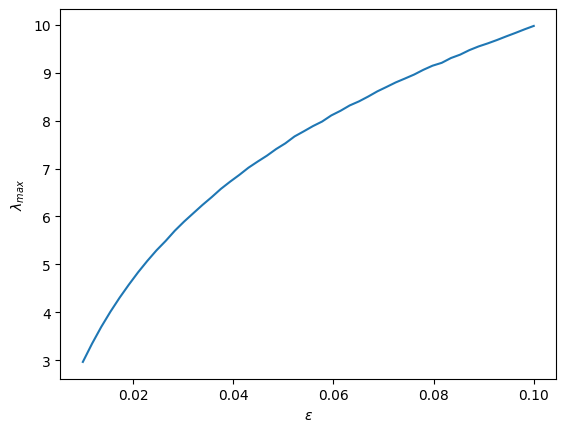

In [12]:
# Calculate the max eigenvalue for a range of epsilon values
epsilon_values = np.linspace(0.01, 0.1, 50)
max_eigenvalues = np.array([calculate_eigenvalue(epsilon) for epsilon in epsilon_values])

# Plot the max eigenvalue as a function of epsilon
import matplotlib.pyplot as plt
plt.plot(epsilon_values, max_eigenvalues)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()
